# Cats vs dogs kaggle challenge

In [1]:
# preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras import preprocessing

# categorical
from tensorflow.keras.utils import to_categorical

# model
from tensorflow.keras.models import Sequential

# layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Flatten, Dense, BatchNormalization, Dropout

# callbacks
from tensorflow.keras.callbacks import EarlyStopping

# backend
from tensorflow.keras import backend as K

# other
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

## 1/ Preprocessing

### Reading in data

The pictures come in jpeg format and we need to transform them into numpy arrays to be able to process them.

In [2]:
def prep_data(path, img_dim, total_pics):
    '''Reads in pictures and converts them into numpy arrays.
    ----------------
    Parameters:
    - path: string - path to pictures
    - img_dim: integer - resolution of the pictures (img_dim x img_dim pixels) 
    - total_pics: integer - number of sampled pictures
    ----------------
    Output:
    - X_array: numpy array of transformed pictures
    - y_array: numpy array indicating whether a pictures shows a dog (1) or cat (0)
    '''
    X = []
    y = []
    count = 0
    
    for p in os.listdir(path):
        count += 1
        category = p.split(".")[0]
        img = image.load_img(path+p, target_size=(img_dim, img_dim))
        img_array = image.img_to_array(img)
        img_array = img_array.astype(np.uint8)
        X.append(img_array)
        if category == 'dog':
            y.append(1)
        else:
            y.append(0)
        if count >= total_pics:
            break
    X_array = np.array(X)
    y_array = np.array(y)
    return X_array, y_array

In [3]:
total_pics = 5_000
img_dim = 120
path = "data/train/"
X, y = prep_data(path, img_dim, total_pics=total_pics)

In [4]:
X.shape, y.shape

((5000, 120, 120, 3), (5000,))

Let's take a look at a random image from our sample.

1

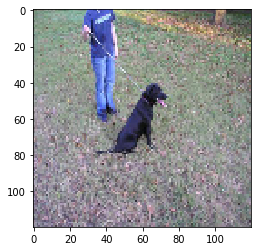

In [5]:
test_image = random.randint(1, total_pics)
plt.imshow(X[test_image])
y[test_image]

To see how many dogs we have in the sample we can simply sum up y as dogs are encoded as 1 and cats as 0. The number of dogs should be approximately half the total sample.

In [6]:
sum(y)

2498

Looking good!

Now let's reshape and normalize the data so our DNN can use it.

In [7]:
# reshape data
y = y.reshape(y.shape + (1,))

In [8]:
# normalize the data
X = X/255 

In [9]:
X.shape, y.shape

((5000, 120, 120, 3), (5000, 1))

In [10]:
X.dtype

dtype('float64')

In [11]:
X.max(), X.min()

(1.0, 0.0)

### Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 120, 120, 3), (1000, 120, 120, 3), (4000, 1), (1000, 1))

### Define plotting functions

These functions will help us evaluate how accuracy and loss evolve with each epoch.

In [13]:
# summarize history for accuracy
def plot_accuracy(history):
    '''Plots accuracy across training epochs.
    ----------
    Parameter:
    - history: fitted DNN
    '''
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [14]:
# summarize history for loss
def plot_loss(history):
    '''Plots loss across training epochs.
    ----------
    Parameter:
    - history: fitted DNN
    '''
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## 2/ DNN from scratch

### Build model

In [15]:
K.clear_session()

In [16]:
# define the model
model = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
           input_shape=(img_dim, img_dim, 3)),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.2), 
    Activation('relu'),
    
    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.2), 
    Activation('relu'), 

    # Flattening 
    Flatten(),
    
    # Output layer
    Dense(1), Activation('sigmoid')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [18]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

### Fit the model

In [19]:
# fit the model
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=250,
                    epochs=5, 
                    validation_split=0.2,
)

Epoch 1/5
13/13 [==============================] - 50s 4s/step - loss: 2.8303 - accuracy: 0.5231 - val_loss: 0.6861 - val_accuracy: 0.5387
Epoch 2/5
13/13 [==============================] - 50s 4s/step - loss: 1.0770 - accuracy: 0.6062 - val_loss: 0.6903 - val_accuracy: 0.5100
Epoch 3/5
13/13 [==============================] - 50s 4s/step - loss: 0.7774 - accuracy: 0.6409 - val_loss: 0.6887 - val_accuracy: 0.5063
Epoch 4/5
13/13 [==============================] - 50s 4s/step - loss: 0.5971 - accuracy: 0.7097 - val_loss: 0.6868 - val_accuracy: 0.5550
Epoch 5/5
13/13 [==============================] - 51s 4s/step - loss: 0.5215 - accuracy: 0.7434 - val_loss: 0.6872 - val_accuracy: 0.5150


### Plot loss and accuracy

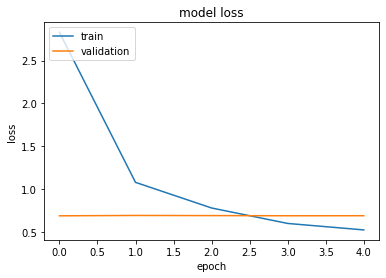

In [20]:
plot_loss(history)

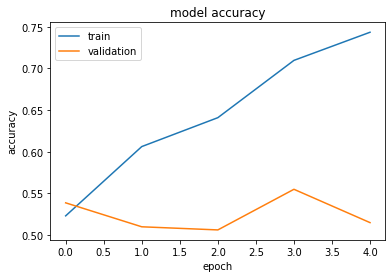

In [21]:
plot_accuracy(history)

In [22]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 2s 58ms/step - loss: 0.6832 - accuracy: 0.5340


[0.6832470297813416, 0.5339999794960022]

Ouch, this does not look good! The model hardly perfoms better than chance. Let's see if we can do better with transfer learning.

## Transfer learning

The performance of the simple, self-built DNN still leaves a lot to be desired, so we will try using one of the prebuilt DNNs available for keras / tensorflow that are trained on the imagenet dataset. To use one of these models, we can simply retrain the last layer for our purpose. 

In [23]:
from tensorflow.keras.applications import Xception

In [24]:
K.clear_session()

In [25]:
model = Sequential()
model.add(Xception(include_top=False, pooling='max', input_shape=(img_dim, img_dim, 3)))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [27]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

### Fit model

In [28]:
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=10,
                    epochs=3, 
                    validation_split=0.2,
)

Epoch 1/3
320/320 [==============================] - 142s 445ms/step - loss: 0.2018 - accuracy: 0.9181 - val_loss: 0.1375 - val_accuracy: 0.9375
Epoch 2/3
320/320 [==============================] - 141s 441ms/step - loss: 0.1376 - accuracy: 0.9463 - val_loss: 0.1198 - val_accuracy: 0.9525
Epoch 3/3
320/320 [==============================] - 132s 413ms/step - loss: 0.1062 - accuracy: 0.9584 - val_loss: 0.1307 - val_accuracy: 0.9488


### Plot loss and accuracy

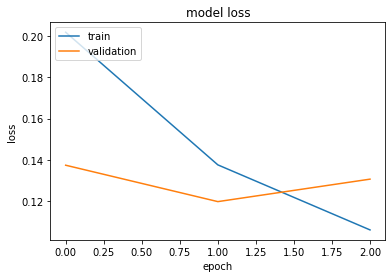

In [29]:
plot_loss(history)

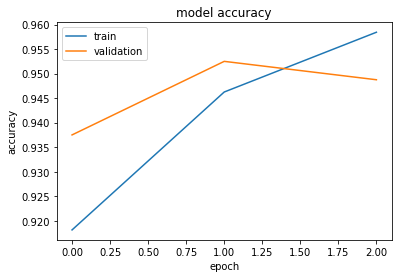

In [30]:
plot_accuracy(history)

In [31]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 24s 746ms/step - loss: 0.1743 - accuracy: 0.9330


[0.17431442439556122, 0.9330000281333923]

### Which images did the transfer learning model get wrong?

In [32]:
y_pred = model.predict(X_test).round()

In [33]:
false_preds = list(i[0] == i[1] for i in zip(y_pred, y_test))

In [34]:
false_preds_positions = []

for i, pred in enumerate(false_preds):
    if pred == False:
        false_preds_positions.append(i)

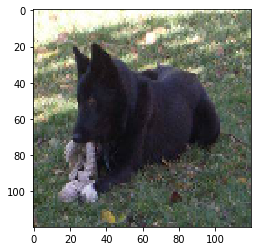

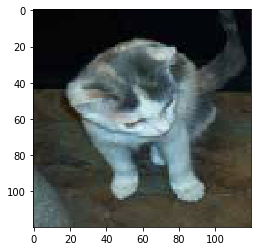

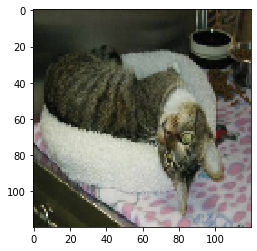

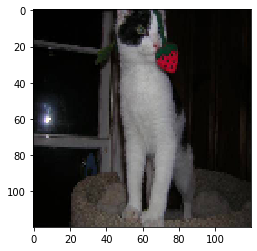

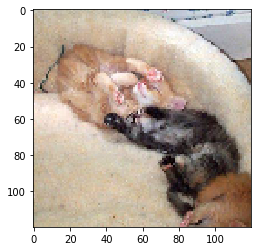

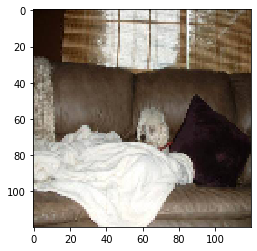

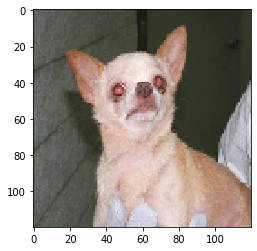

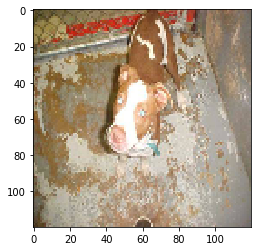

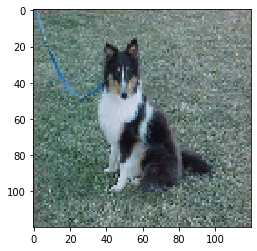

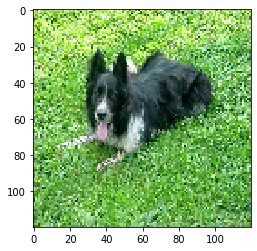

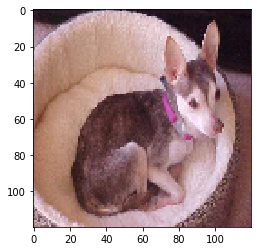

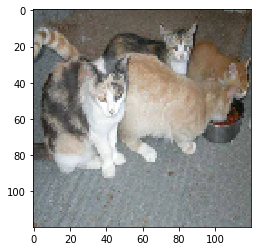

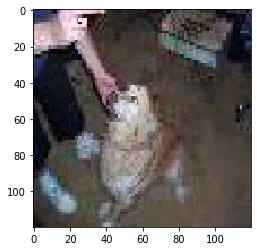

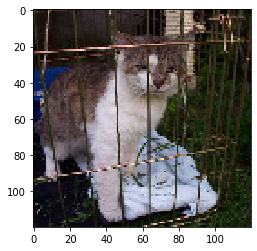

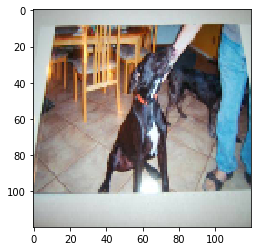

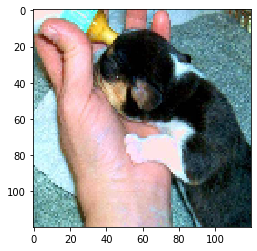

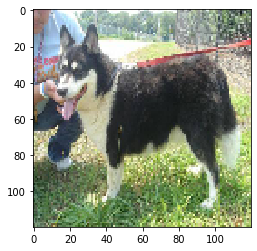

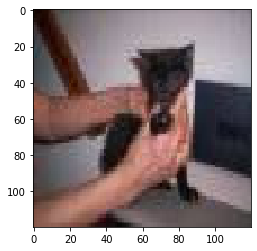

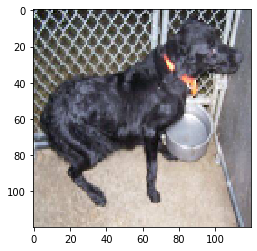

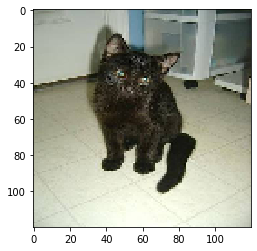

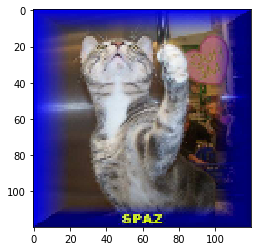

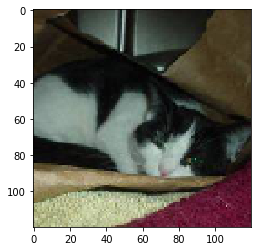

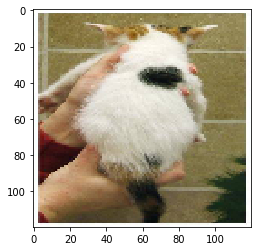

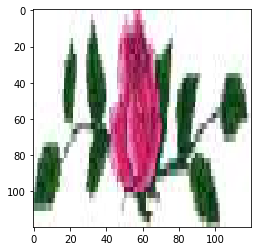

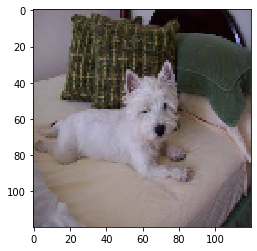

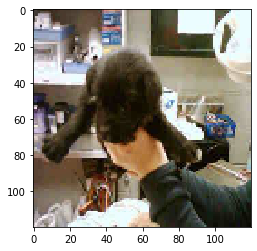

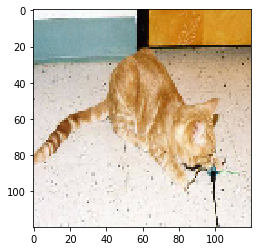

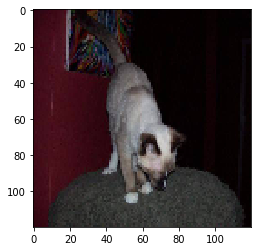

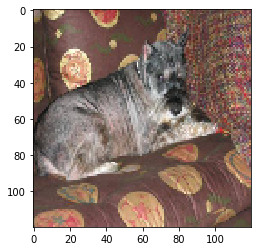

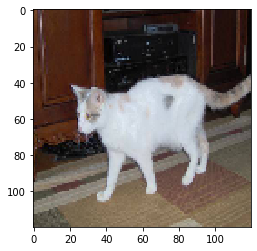

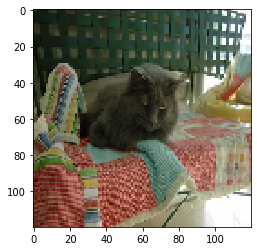

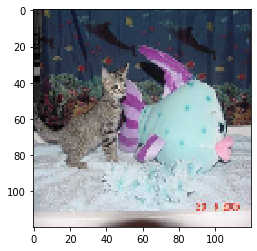

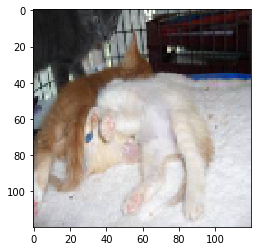

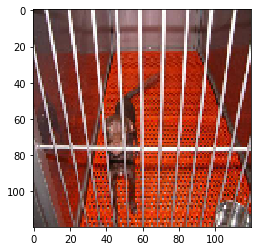

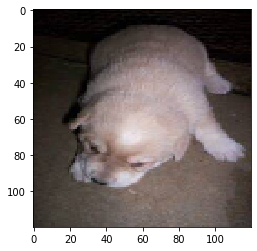

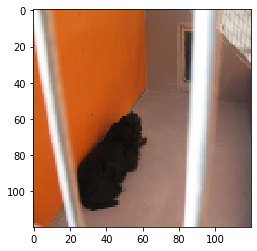

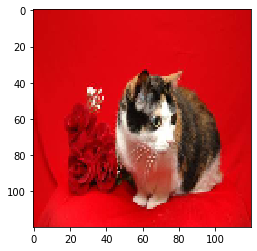

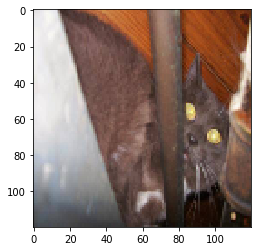

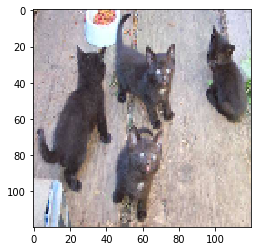

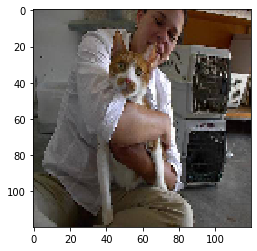

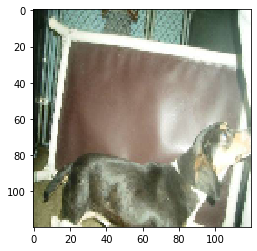

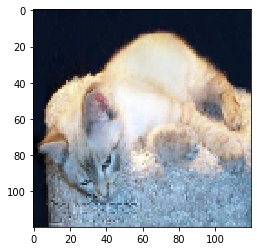

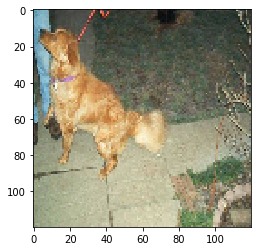

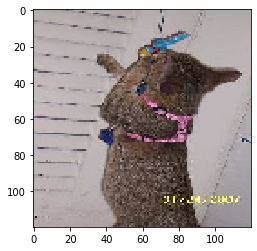

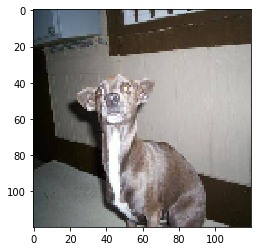

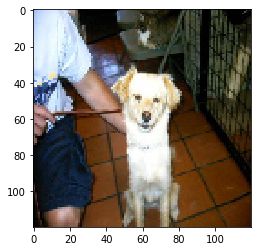

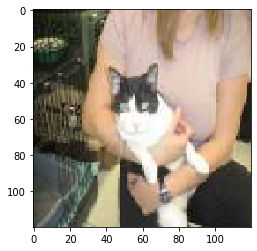

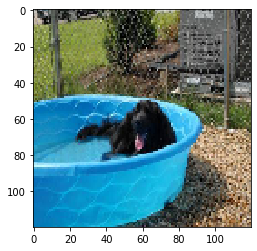

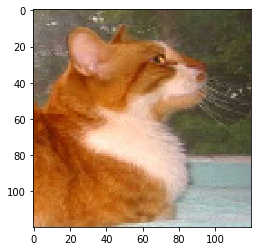

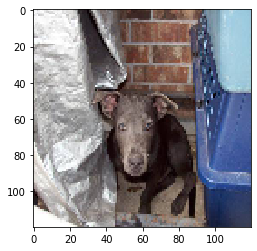

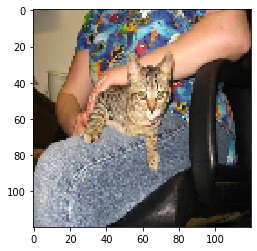

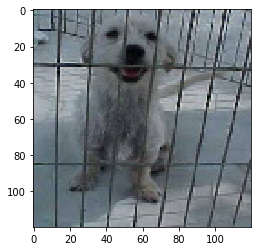

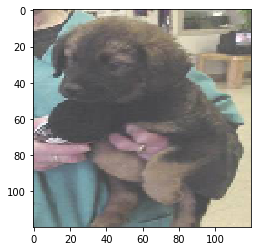

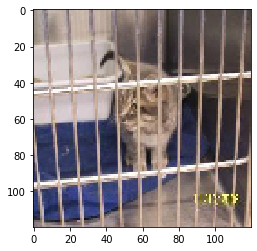

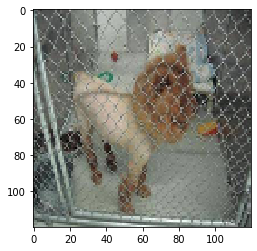

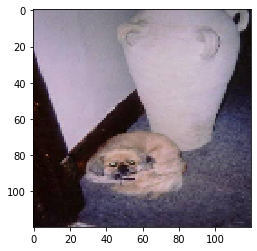

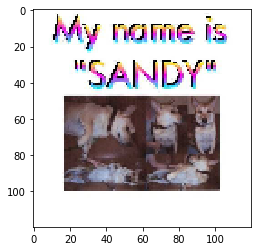

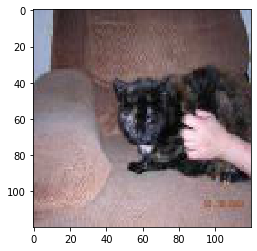

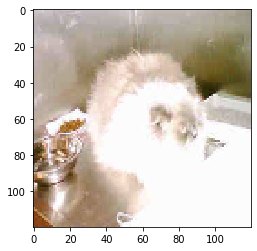

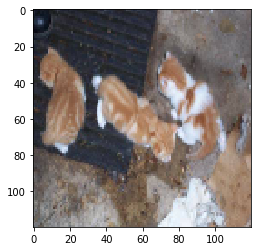

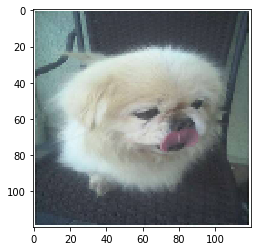

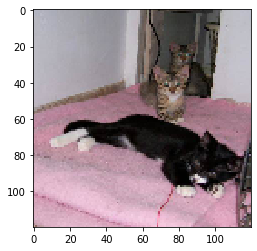

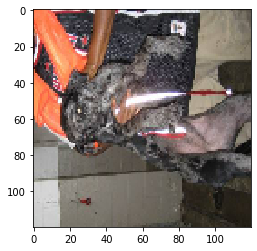

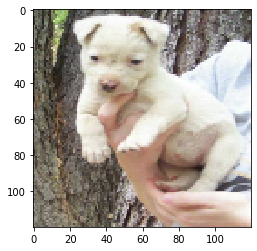

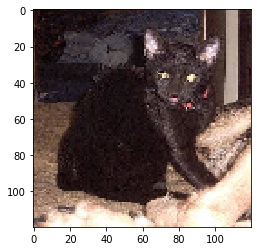

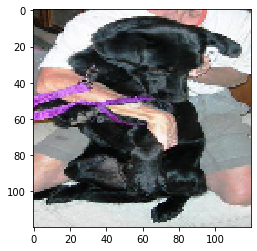

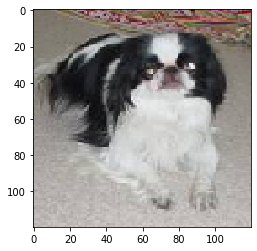

In [35]:
for i in false_preds_positions:
    plt.imshow(X_test[i])
    plt.show()